In [1]:
import torch
import time
from src.ml.services.model_loader import model_manager
from src.ml.services.data_mnist import test_loader_mnist
import pandas as pd
from openpyxl import Workbook
from openpyxl.styles import PatternFill
import matplotlib.pyplot as plt
import os


+ Perceptron 
+ MLP 
+ CNN 


In [4]:
nns = model_manager.get_available_models()
xi, yi = next(iter(test_loader_mnist))

In [106]:
perceptron = model_manager.get_model(nns[0])

bias_param = dict(perceptron.named_parameters())["func1.bias"].detach().cpu().numpy()

weights = {}
for name, param in perceptron.named_parameters():
    if "weight" in name:
        W = param.detach().cpu().numpy()
        for j in range(W.shape[0]):
            weights[j] = W[j].reshape(28, 28)


xi, yi = next(iter(test_loader_mnist))
tensor_img = xi[0].float().squeeze().numpy()


wb = Workbook()

ws_tensor = wb.active
ws_tensor.title = "tensor"

df_tensor = pd.DataFrame(tensor_img)
for r in df_tensor.itertuples(index=False):
    ws_tensor.append(r)

for col in ws_tensor.columns:
    col_letter = col[0].column_letter
    ws_tensor.column_dimensions[col_letter].width = 4

    for cell in col:
        if cell.value is None:
            continue
        cell.number_format = "0.0"
        val = float(cell.value)
        shade = int((1 - val) * 255)
        hex_color = f"{shade:02x}{shade:02x}{shade:02x}"
        cell.fill = PatternFill(start_color=hex_color, end_color=hex_color, fill_type="solid")


ws_w = wb.create_sheet("weights")

row_ptr = 1
for j in range(len(weights)):
    ws_w.cell(row=row_ptr, column=1, value=f"Neuron {j} weights")
    row_ptr += 1

    matrix = weights[j]

    for r in matrix:
        for c in range(28):
            ws_w.cell(row=row_ptr, column=c+1, value=float(r[c]))
        row_ptr += 1

    row_ptr += 2

ws_b = wb.create_sheet("biases")
ws_b.cell(row=1, column=1, value="Neuron")
ws_b.cell(row=1, column=2, value="Bias")

for j, b in enumerate(bias_param):
    ws_b.cell(row=j+2, column=1, value=j)
    ws_b.cell(row=j+2, column=2, value=float(b))


ws_c = wb.create_sheet("combined")

ws_c.cell(row=1, column=1, value="Input tensor")
for r in range(28):
    for c in range(28):
        v = float(tensor_img[r][c])
        cell = ws_c.cell(row=r+2, column=c+1, value=v)
        cell.number_format = "0.0"
        shade = int((1 - v) * 255)
        hex_color = f"{shade:02x}{shade:02x}{shade:02x}"
        cell.fill = PatternFill(start_color=hex_color, end_color=hex_color, fill_type="solid")

for c in range(1, 29):
    ws_c.column_dimensions[ws_c.cell(row=2, column=c).column_letter].width = 4


start_col_w = 30
row_ptr = 2

ws_c.cell(row=1, column=start_col_w, value="WEIGHTS (heatmap red-blue)")

for j in range(len(weights)):
    ws_c.cell(row=row_ptr, column=start_col_w, value=f"Neuron {j}")
    row_ptr += 1

    matrix = weights[j]

    w_min = matrix.min()
    w_max = matrix.max()

    if w_max != w_min:
        norm_matrix = (matrix - w_min) / (w_max - w_min)
        norm_matrix = norm_matrix * 2 - 1
    else:
        norm_matrix = matrix * 0 

    for r in range(28):
        for c in range(28):
            v = float(matrix[r][c])
            norm = float(norm_matrix[r][c])

            if norm < 0:
                t = int((norm + 1) * 255)
                R = t
                G = t
                B = 255
            else:
                t = int((1 - norm) * 255)
                R = 255
                G = t
                B = t

            hex_color = f"{R:02x}{G:02x}{B:02x}"

            cell = ws_c.cell(row=row_ptr, column=start_col_w + c, value=v)
            cell.number_format = "0.00"
            cell.fill = PatternFill(start_color=hex_color, end_color=hex_color, fill_type="solid")

        row_ptr += 1

    row_ptr += 2


wb.save("FINAL.xlsx")


In [8]:
it = iter(test_loader_mnist)
xi, yi = next(it)
x_single = xi[0].unsqueeze(0)
print(yi[0])
logits = perceptron(x_single)
print(logits)
probs = torch.softmax(logits, dim=1).detach().cpu().numpy()[0]
for cls, p in enumerate(probs):
    print(f"Class {cls}: {p:.4f}")


tensor(7)
tensor([[ -2.8525, -11.5738,  -2.0660,   2.0753,  -5.4804,  -2.5652,  -9.6353,
           7.5485,  -2.0958,   0.6814,  -5.5104]], grad_fn=<AddmmBackward0>)
Class 0: 0.0000
Class 1: 0.0000
Class 2: 0.0001
Class 3: 0.0042
Class 4: 0.0000
Class 5: 0.0000
Class 6: 0.0000
Class 7: 0.9946
Class 8: 0.0001
Class 9: 0.0010
Class 10: 0.0000


In [6]:
# ПОКАЗАТЬ СТРУКТУРУ CNN
nn_list = ["Per", "MLP", "CNN"]
for i, nn in enumerate(nn_list):
    print(f"================ {nn} ================")
    cnn = model_manager.get_model(nns[i])
    logits = cnn(xi)
    for name, act in cnn.activations.items():
        print(f"{name:10s} → shape = {tuple(act.shape)}")


================ Per ================
output     → shape = (128, 784)
================ MLP ================
hidden_layer_1 → shape = (128, 128)
hidden_layer_2 → shape = (128, 128)
output     → shape = (128, 11)
================ CNN ================
conv1      → shape = (128, 32, 28, 28)
pool1      → shape = (128, 32, 14, 14)
conv2      → shape = (128, 64, 14, 14)
pool2      → shape = (128, 64, 7, 7)
fc1        → shape = (128, 128)
dropout    → shape = (128, 128)
output     → shape = (128, 11)


In [1]:

mlp = model_manager.get_model("MLP")
mlp.eval()
_ = mlp(xi[0:1])

fc1_weights = mlp.fc1.weight.detach().cpu().numpy()
fc2_weights = mlp.fc2.weight.detach().cpu().numpy()
fc1_acts = mlp.activations["hidden_layer_1"][0].detach().cpu().numpy()
fc2_acts = mlp.activations["output"][0].detach().cpu().numpy()
softmax_probs = torch.softmax(torch.tensor(fc2_acts), dim=0).numpy()

plt.figure(figsize=(12,6))
plt.imshow(fc1_weights, aspect='auto', cmap='bwr')
plt.title("Веса FC1 (784 → 128)")
plt.xlabel("Индекс входного нейрона")
plt.ylabel("Индекс нейронов FC1")
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

plt.figure(figsize=(12,4))
plt.plot(fc1_acts, color='black')
plt.title("Активации FC1")
plt.xlabel("Нейронный индекс")
plt.ylabel("Значение активации")
plt.grid(True)
plt.show()

plt.figure(figsize=(12,4))
plt.imshow(fc2_weights, aspect='auto', cmap='bwr')
plt.title("Веса FC2 (128 → 11)")
plt.xlabel("Индекс нейронов FC1")
plt.ylabel("Индекс нейронов FC2")
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

plt.figure(figsize=(8,4))
plt.bar(range(fc2_acts.shape[0]), fc2_acts, color='black')
plt.title("Выходные логиты")
plt.xlabel("Логиты")
plt.ylabel("Значение активаций")
plt.show()

plt.figure(figsize=(8,4))
plt.bar(range(len(softmax_probs)), softmax_probs, color='black')
plt.title("Softmax вероятность")
plt.xlabel("Класс")
plt.ylabel("Вероятность")
plt.show()


NameError: name 'model_manager' is not defined

C:\Users\user\AppData\Local\Temp\ipykernel_13536\2176238136.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


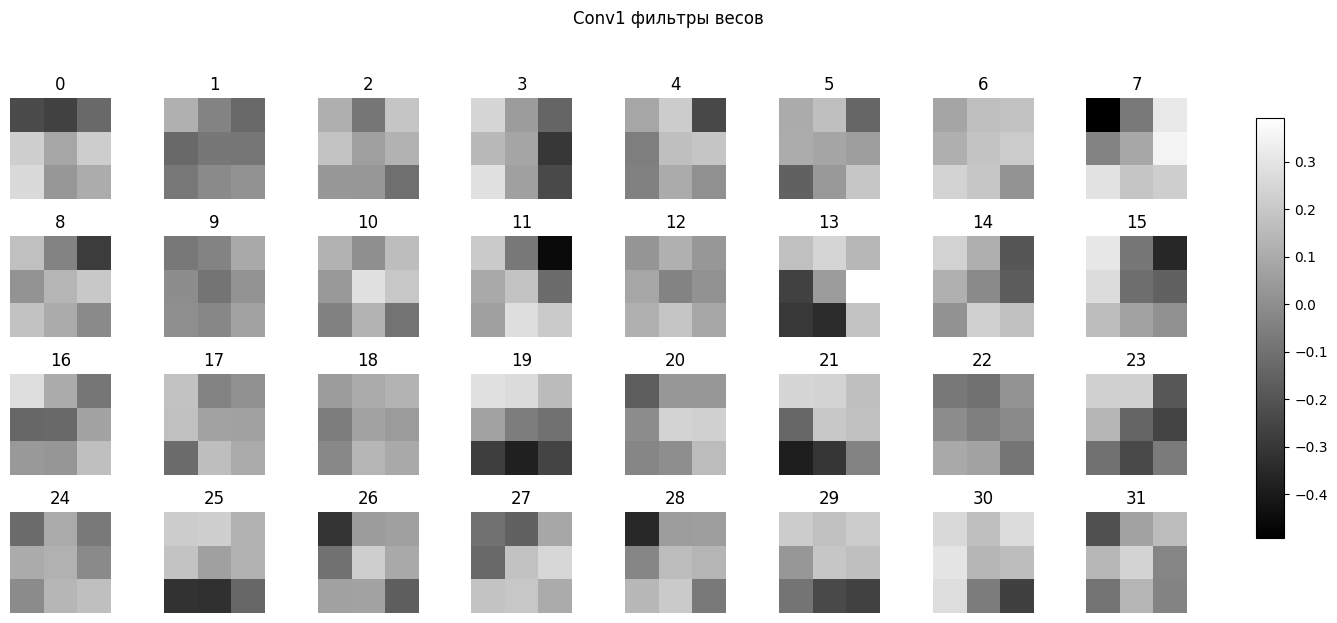

C:\Users\user\AppData\Local\Temp\ipykernel_13536\2176238136.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


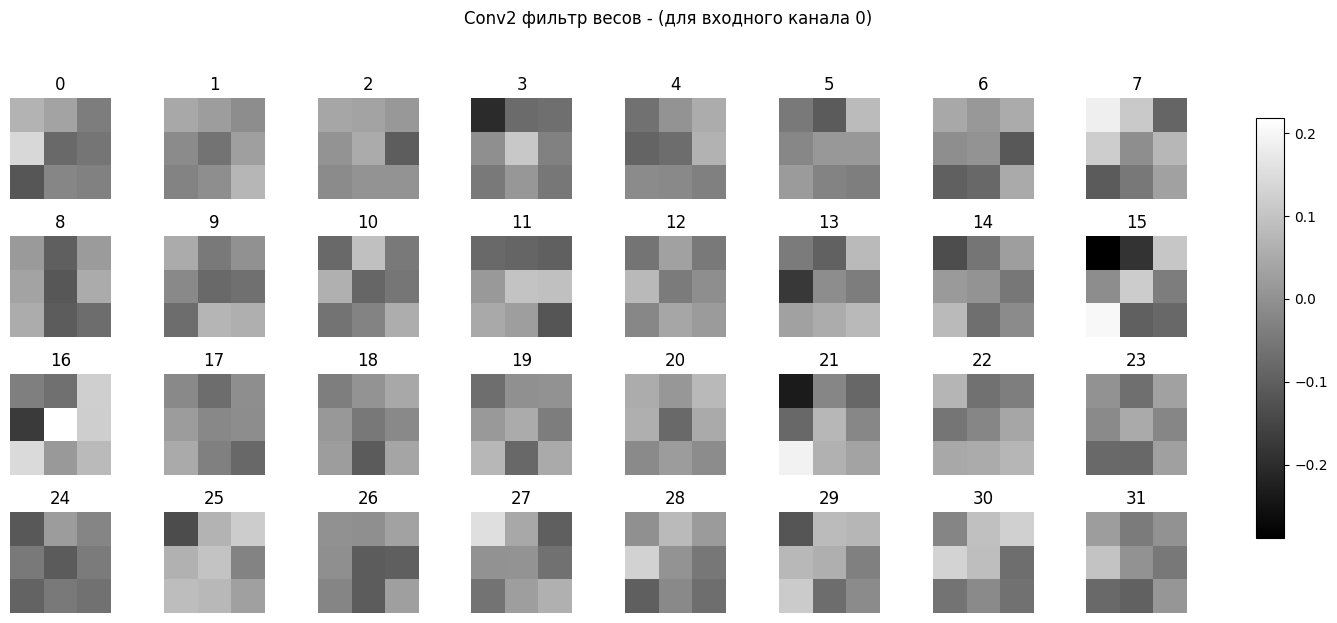

In [13]:
filters = cnn.conv1.weight.data.clone().detach().cpu()
num_filters = filters.shape[0]

vmin = filters.min()
vmax = filters.max()

plt.figure(figsize=(14, 6))

for i in range(num_filters):
    plt.subplot(4, 8, i + 1)
    img = plt.imshow(filters[i, 0, :, :], cmap='gray', vmin=vmin, vmax=vmax)
    plt.axis('off')
    plt.title(f"{i}")

plt.suptitle("Conv1 фильтры весов", y=1.03)

cbar_ax = plt.gcf().add_axes([0.92, 0.15, 0.02, 0.7])
plt.colorbar(img, cax=cbar_ax)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

filters = cnn.conv2.weight.data.clone().detach().cpu()
filter_id = 0
single_filter = filters[filter_id]
num_channels = single_filter.shape[0]

vmin = single_filter.min()
vmax = single_filter.max()

plt.figure(figsize=(14, 6))

for i in range(num_channels):
    plt.subplot(4, 8, i + 1)
    img = plt.imshow(single_filter[i, :, :], cmap='gray', vmin=vmin, vmax=vmax)
    plt.axis('off')
    plt.title(f"{i}")

plt.suptitle(f"Conv2 фильтр весов - (для входного канала {filter_id})", y=1.03)

cbar_ax = plt.gcf().add_axes([0.92, 0.15, 0.02, 0.7])
plt.colorbar(img, cax=cbar_ax)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_13536\3668020737.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


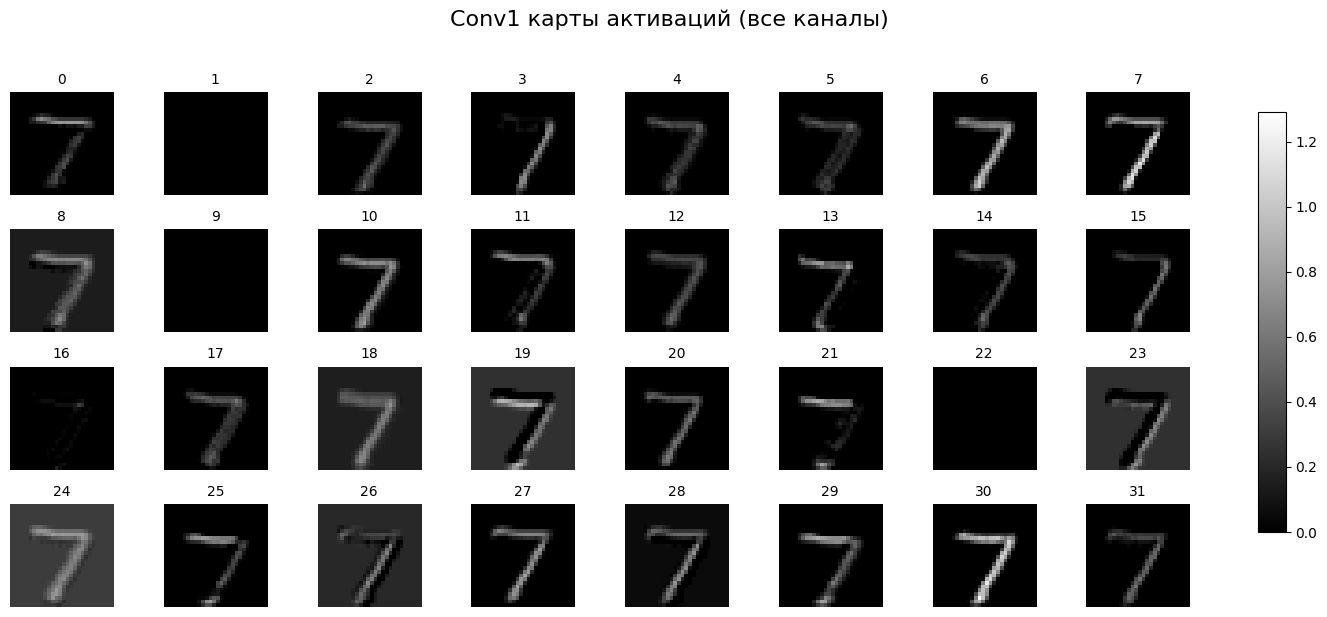

C:\Users\user\AppData\Local\Temp\ipykernel_13536\3668020737.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


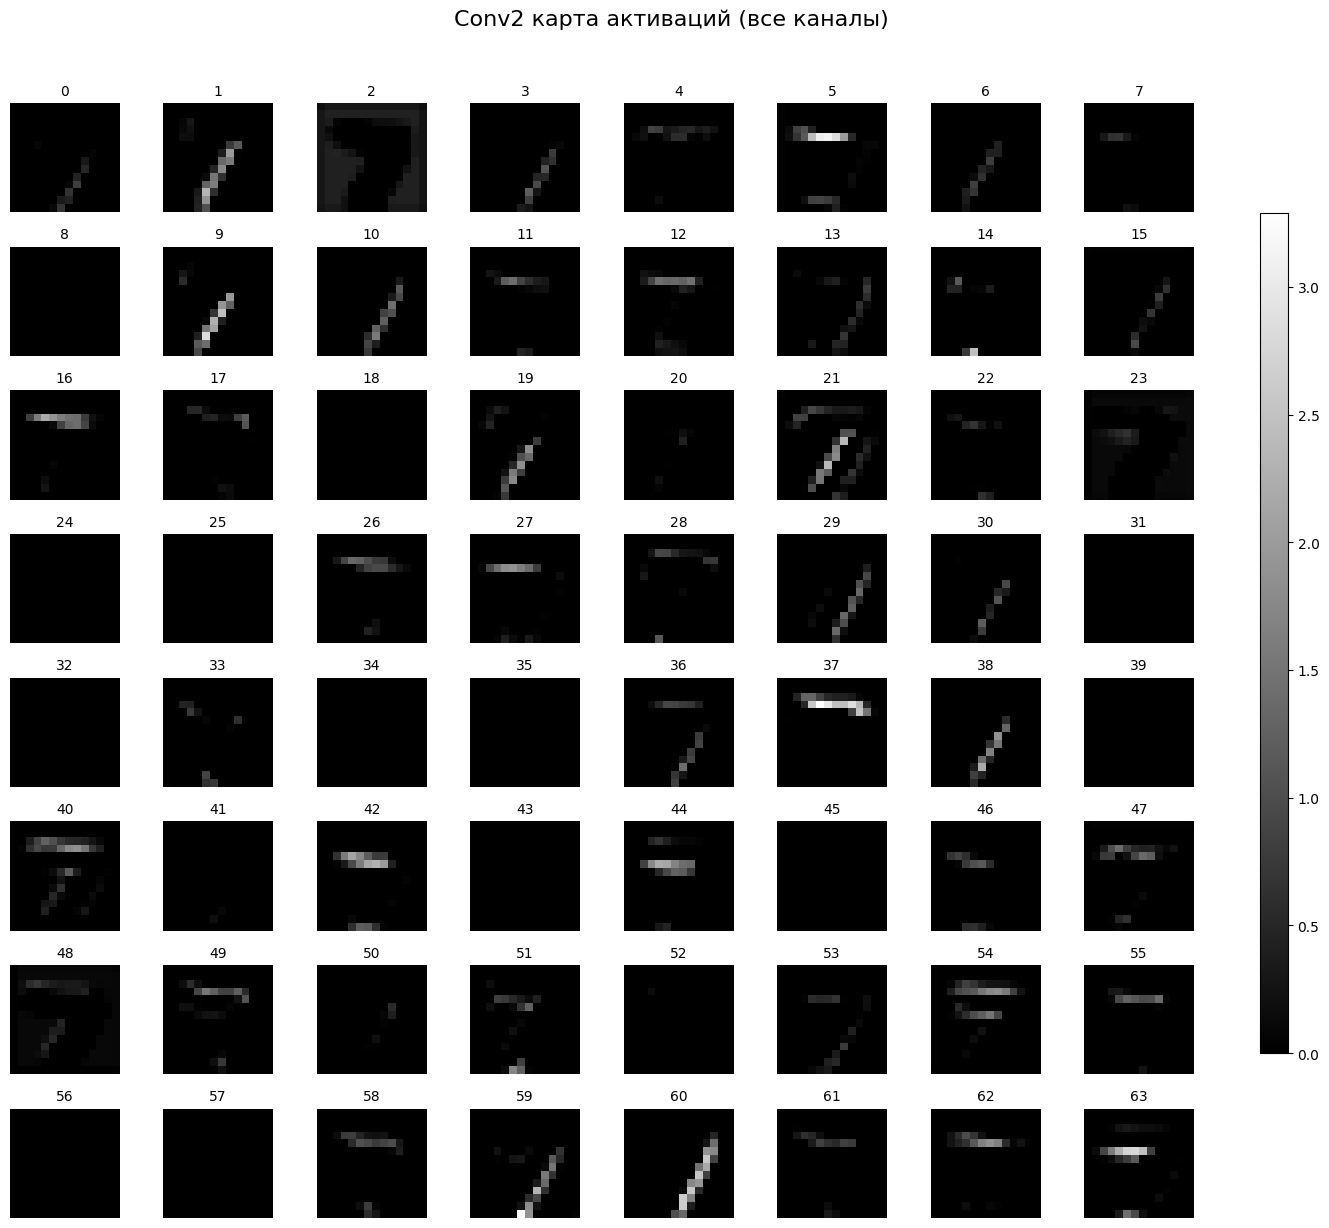

In [14]:
conv1_acts = cnn.activations["conv1"][0].detach().cpu()  
num_maps = conv1_acts.shape[0]

vmin = conv1_acts.min()
vmax = conv1_acts.max()

plt.figure(figsize=(14, 6))

for i in range(num_maps):
    plt.subplot(4, 8, i + 1)
    img = plt.imshow(conv1_acts[i].numpy(), cmap='gray', vmin=vmin, vmax=vmax)
    plt.axis('off')
    plt.title(f"{i}", fontsize=10)

plt.suptitle("Conv1 карты активаций (все каналы)", fontsize=16, y=1.02)

cbar_ax = plt.gcf().add_axes([0.92, 0.15, 0.02, 0.7])
plt.colorbar(img, cax=cbar_ax)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

conv2_acts = cnn.activations["conv2"][0].detach().cpu() 

conv2_first_channel = conv2_acts[:, :, :] 
num_maps = conv2_first_channel.shape[0]

vmin = conv2_first_channel.min()
vmax = conv2_first_channel.max()

plt.figure(figsize=(14, 12))

for i in range(num_maps):
    plt.subplot(8, 8, i + 1)
    img = plt.imshow(conv2_first_channel[i].numpy(), cmap='gray', vmin=vmin, vmax=vmax)
    plt.axis('off')
    plt.title(f"{i}", fontsize=10)

plt.suptitle("Conv2 карта активаций (все каналы)", fontsize=16, y=1.02)

cbar_ax = plt.gcf().add_axes([0.92, 0.15, 0.02, 0.7])
plt.colorbar(img, cax=cbar_ax)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

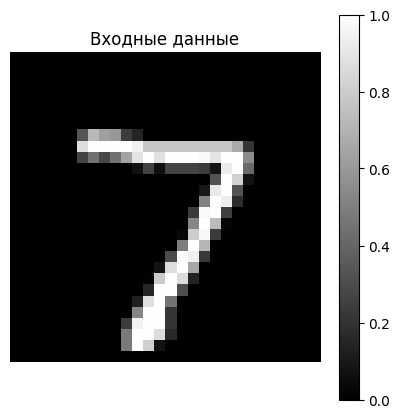

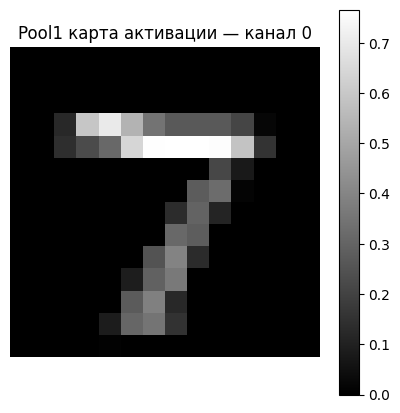

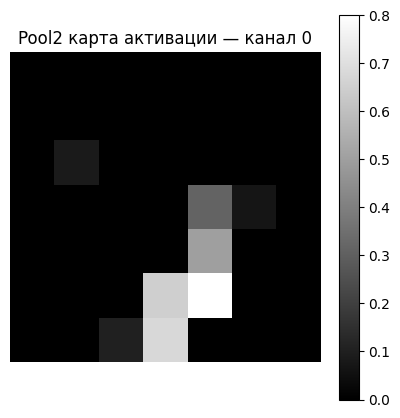

In [98]:
plt.figure(figsize=(5,5))
plt.imshow(xi[0].squeeze(dim=0), cmap='gray')
plt.colorbar()
plt.title("Входные данные")
plt.axis("off")
plt.show()
pool1_acts = cnn.activations["pool1"][0].detach().cpu()
feature_map = pool1_acts[0].numpy()

plt.figure(figsize=(5,5))
plt.imshow(feature_map, cmap='gray')
plt.colorbar()
plt.title("Pool1 карта активации — канал 0")
plt.axis("off")
plt.show()

pool2_acts = cnn.activations["pool2"][0].detach().cpu()
feature_map = pool2_acts[0].numpy()

plt.figure(figsize=(5,5))
plt.imshow(feature_map, cmap='gray')
plt.colorbar()
plt.title("Pool2 карта активации — канал 0")
plt.axis("off")
plt.show()


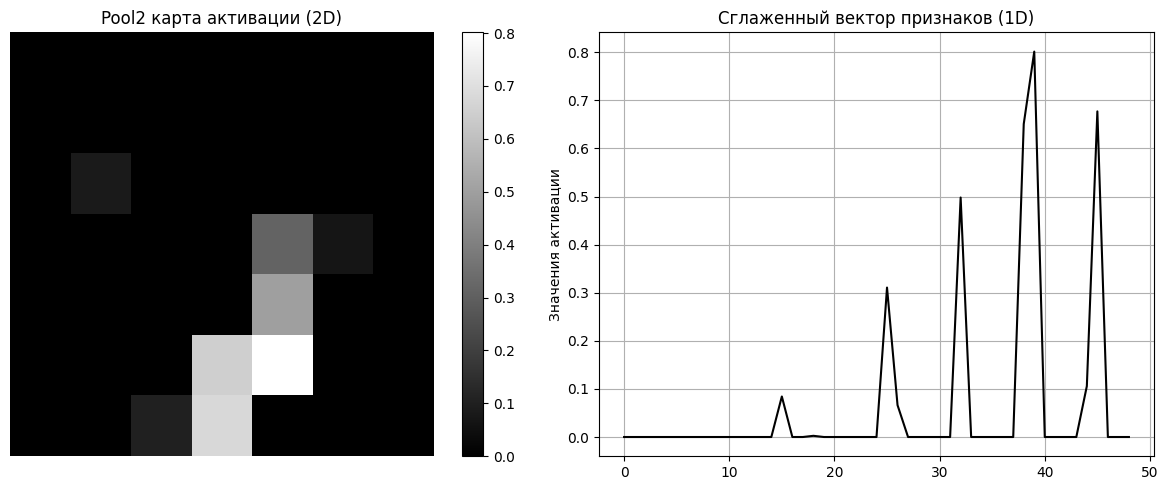

In [97]:
pool_acts = cnn.activations[f"pool2"][0].detach().cpu()
feature_map_2d = pool_acts[0].numpy() 

x_flat = pool_acts[0].view(-1).detach().cpu().numpy()
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(feature_map_2d, cmap='gray')
plt.colorbar()
plt.title(f"Pool2 карта активации (2D)")
plt.axis("off")

plt.subplot(1,2,2)
plt.plot(x_flat, color='black')
plt.title("Сглаженный вектор признаков (1D)")
plt.ylabel("Значения активации")
plt.grid(True)

plt.tight_layout()
plt.show()

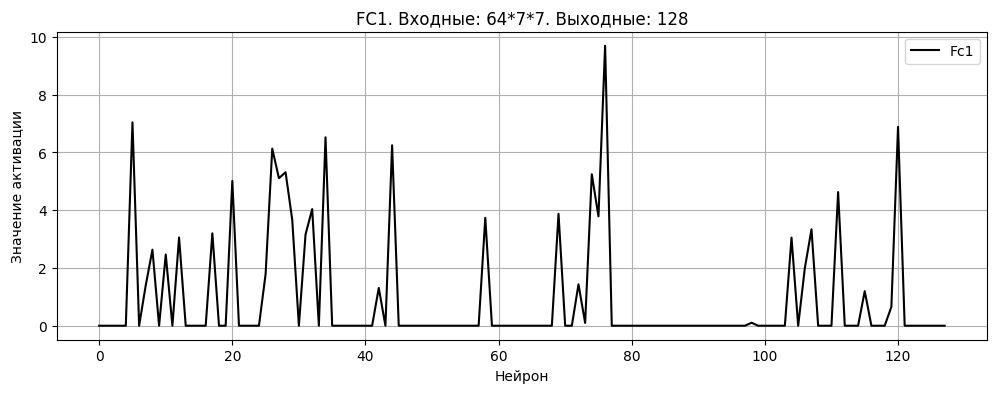

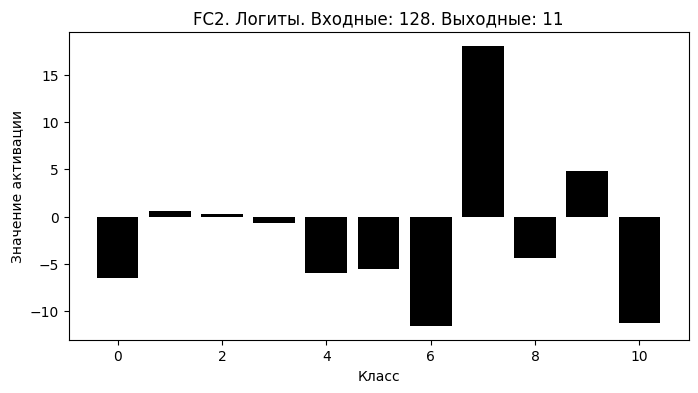

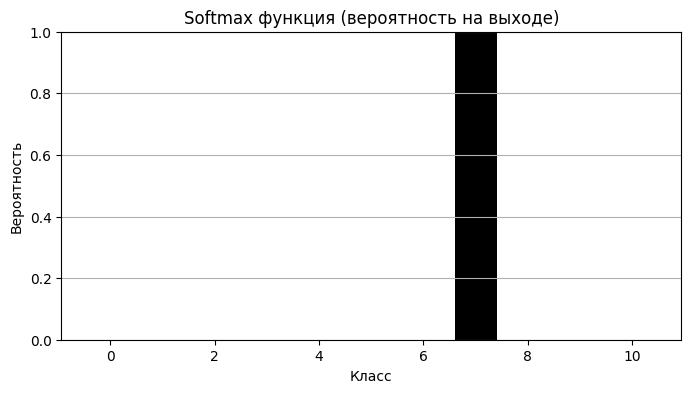

In [127]:
fc1_acts = cnn.activations["fc1"][0].detach().cpu()  

plt.figure(figsize=(12,4))
plt.plot(fc1_acts.numpy(), color='black', label='Fc1')
plt.title("FC1. Входные: 64*7*7. Выходные: 128")
plt.xlabel("Нейрон")
plt.ylabel("Значение активации")
plt.grid(True)
plt.legend()
plt.show()

fc2_acts = cnn.activations["output"][0].detach().cpu()

plt.figure(figsize=(8,4))
plt.bar(range(fc2_acts.numel()), fc2_acts.numpy(), color='black')
plt.title("FC2. Логиты. Входные: 128. Выходные: 11")
plt.xlabel("Класс")
plt.ylabel("Значение активации")
plt.show()

softmax_probs = torch.softmax(fc2_acts, dim=0).numpy()

plt.figure(figsize=(8,4))
plt.bar(range(len(softmax_probs)), softmax_probs, color='black')
plt.title("Softmax функция (вероятность на выходе)")
plt.xlabel("Класс")
plt.ylabel("Вероятность")
plt.ylim(0,1)
plt.grid(axis='y')
plt.show()


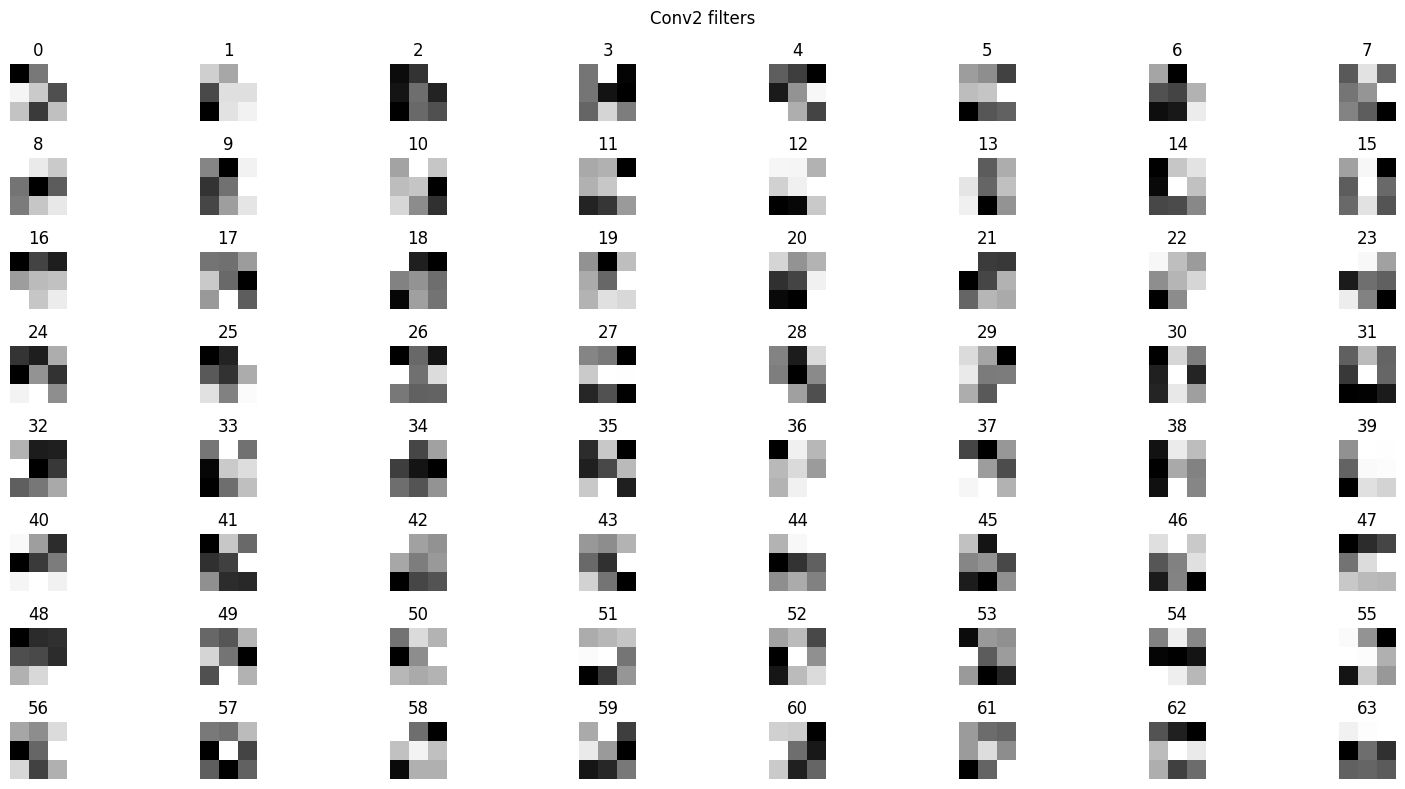

In [68]:
filters = cnn.conv2.weight.data.clone().detach().cpu()

plt.figure(figsize=(16, 8))
for i in range(64):
    plt.subplot(8, 8, i+1)
    filter_mean = filters[i].mean(dim=0)
    plt.imshow(filter_mean, cmap='gray')
    plt.axis('off')
    plt.title(f"{i}")
plt.suptitle("Conv2 filters")
plt.tight_layout()
plt.show()


In [88]:
def save_conv_demo(input_tensor, conv_layer, filter_idx=0, layer_name="conv1", folder="conv_demo"):

    os.makedirs(folder, exist_ok=True)

    if input_tensor.ndim == 3:
        x_batch = input_tensor.unsqueeze(0)
    else:
        x_batch = input_tensor 

    kernel_tensor = conv_layer.weight.data[filter_idx, 0, :, :].unsqueeze(0).unsqueeze(0)
    
    feature_map = torch.functional.conv2d(x_batch, kernel_tensor, bias=None, stride=1, padding=conv_layer.padding[0])
    feature_map = feature_map[0, 0].detach().cpu().numpy()

    x_img = x_batch[0,0].detach().cpu().numpy()
    kernel = kernel_tensor[0,0].detach().cpu().numpy()

    plt.figure(figsize=(9,3))

    plt.subplot(1,3,1)
    plt.imshow(x_img, cmap='gray')
    plt.title("Input image")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(kernel, cmap='gray')
    plt.title(f"Filter {filter_idx}")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(feature_map, cmap='bwr', vmin=feature_map.min(), vmax=feature_map.max())
    plt.title("Feature map")
    plt.axis("off")

    path = f"{folder}/{layer_name}_filter_{filter_idx}.png"
    plt.tight_layout()
    plt.savefig(path, dpi=200, bbox_inches='tight')
    plt.close()

    print(f"Saved: {path}")

xi_in, _ = next(iter(test_loader_mnist))
save_conv_demo(xi_in[0], cnn.conv1, filter_idx=0, layer_name="conv1")
save_conv_demo(xi_in[0], cnn.conv2, filter_idx=5, layer_name="conv2")


Saved: conv_demo/conv1_filter_0.png
Saved: conv_demo/conv2_filter_5.png


In [10]:
def save_conv_demo_correct(activations, layer_name, cnn_model, input_image, folder="conv_demo_correct"):

    os.makedirs(folder, exist_ok=True)
    
    tensor = activations[layer_name][0].detach().cpu()
    n_channels = tensor.shape[0]
    conv_layer = getattr(cnn_model, layer_name)
    
    if layer_name == "conv1":
        x_img = input_image.detach().cpu().numpy().squeeze()
        for i in range(n_channels):
            plt.figure(figsize=(10,3))
            plt.subplot(1,3,1)
            plt.imshow(x_img, cmap='gray')
            plt.title(f"Input to {layer_name}")
            plt.axis("off")
            plt.subplot(1,3,2)
            kernel = conv_layer.weight.data[i,0].detach().cpu().numpy()
            im_kernel = plt.imshow(kernel, cmap='gray')
            plt.colorbar(im_kernel, fraction=0.046, pad=0.04)
            plt.title(f"Filter {i}")
            plt.axis("off")
            plt.subplot(1,3,3)
            feature_map = tensor[i].numpy()
            plt.imshow(feature_map, cmap='bwr', vmin=feature_map.min(), vmax=feature_map.max())
            plt.title("Feature map")
            plt.axis("off")
            plt.colorbar(fraction=0.046, pad=0.04)
            path = f"{folder}/{layer_name}_filter_{i}_correct.png"
            plt.tight_layout()
            plt.savefig(path, dpi=200, bbox_inches='tight')
            plt.close()
            print(f"Saved: {path}")
    else:
        prev_layer = "relu1" if "relu1" in activations else "conv1"
        prev_activations = activations[prev_layer][0].detach().cpu().numpy() 

        first_filter = conv_layer.weight.data[0].detach().cpu().numpy() 

        n_prev_channels = prev_activations.shape[0]
        for c in range(n_prev_channels):
            plt.figure(figsize=(10,3))
            plt.subplot(1,3,1)
            plt.imshow(prev_activations[c], cmap='gray')
            plt.title(f"Input channel {c}")
            plt.axis("off")
            plt.subplot(1,3,2)
            plt.imshow(first_filter[c], cmap='gray')
            plt.title(f"Filter slice {c}")
            plt.axis("off")
            if c == 0:
                feature_map_sum = tensor[0].numpy()
            plt.subplot(1,3,3)
            plt.imshow(feature_map_sum, cmap='bwr', vmin=feature_map_sum.min(), vmax=feature_map_sum.max())
            plt.title("Feature map")
            plt.axis("off")
            plt.colorbar(fraction=0.046, pad=0.04)
            path = f"{folder}/{layer_name}_filter1_channel_{c}.png"
            plt.tight_layout()
            plt.savefig(path, dpi=200, bbox_inches='tight')
            plt.close()
            print(f"Saved: {path}")

xi_in, _ = next(iter(test_loader_mnist))
save_conv_demo_correct(cnn.activations, "conv1", cnn, xi_in[0])
save_conv_demo_correct(cnn.activations, "conv2", cnn, xi_in[0])


Saved: conv_demo_correct/conv1_filter_0_correct.png
Saved: conv_demo_correct/conv1_filter_1_correct.png
Saved: conv_demo_correct/conv1_filter_2_correct.png
Saved: conv_demo_correct/conv1_filter_3_correct.png
Saved: conv_demo_correct/conv1_filter_4_correct.png
Saved: conv_demo_correct/conv1_filter_5_correct.png
Saved: conv_demo_correct/conv1_filter_6_correct.png
Saved: conv_demo_correct/conv1_filter_7_correct.png
Saved: conv_demo_correct/conv1_filter_8_correct.png
Saved: conv_demo_correct/conv1_filter_9_correct.png
Saved: conv_demo_correct/conv1_filter_10_correct.png
Saved: conv_demo_correct/conv1_filter_11_correct.png
Saved: conv_demo_correct/conv1_filter_12_correct.png
Saved: conv_demo_correct/conv1_filter_13_correct.png
Saved: conv_demo_correct/conv1_filter_14_correct.png
Saved: conv_demo_correct/conv1_filter_15_correct.png
Saved: conv_demo_correct/conv1_filter_16_correct.png
Saved: conv_demo_correct/conv1_filter_17_correct.png
Saved: conv_demo_correct/conv1_filter_18_correct.png
Sav

In [105]:
def save_conv_demo_compact(activations, layer_name, cnn_model, input_image, folder="conv_demo_compact", filters_per_fig=8):
    """
    Визуализируем фильтры + одну feature map на одной фигуре.

    Args:
        activations: dict с активациями (cnn.activations)
        layer_name: 'conv1' или 'conv2'
        cnn_model: сам CNN, чтобы взять веса фильтров
        input_image: исходное изображение [1,28,28]
        folder: папка для сохранения
        filters_per_fig: сколько фильтров показывать на одной фигуре
    """
    os.makedirs(folder, exist_ok=True)
    
    tensor = activations[layer_name][0].detach().cpu() 
    n_channels = tensor.shape[0]
    conv_layer = getattr(cnn_model, layer_name)
    
    if layer_name == "conv1":
        x_img = input_image.detach().cpu().numpy().squeeze()
    else:
        prev_layer = "relu1" if "relu1" in activations else "conv1"
        prev_activations = activations[prev_layer][0].detach().cpu().numpy()
        x_img = prev_activations 

    show_all_channels = layer_name == "conv1"

    for start in range(0, n_channels, filters_per_fig):
        end = min(start + filters_per_fig, n_channels)
        plt.figure(figsize=(3*filters_per_fig,4))

        for idx, i in enumerate(range(start, end)):
            plt.subplot(2, filters_per_fig, idx+1)
            if layer_name == "conv1":
                kernel = conv_layer.weight.data[i,0].detach().cpu().numpy()
            else:
                kernel = conv_layer.weight.data[i,0].detach().cpu().numpy() 
            plt.imshow(kernel, cmap='gray')
            plt.axis("off")
            plt.title(f"Filter {i}")

            plt.subplot(2, filters_per_fig, idx+1+filters_per_fig)
            feature_map = tensor[i].numpy()
            plt.imshow(feature_map, cmap='bwr', vmin=feature_map.min(), vmax=feature_map.max())
            plt.axis("off")
            plt.title(f"Feature {i}")

        path = f"{folder}/{layer_name}_filters_{start}_{end-1}.png"
        plt.tight_layout()
        plt.savefig(path, dpi=200, bbox_inches='tight')
        plt.close()
        print(f"Saved: {path}")


xi_in, _ = next(iter(test_loader_mnist))
save_conv_demo_compact(cnn.activations, "conv1", cnn, xi_in[0])
save_conv_demo_compact(cnn.activations, "conv2", cnn, xi_in[0])


Saved: conv_demo_compact/conv1_filters_0_7.png
Saved: conv_demo_compact/conv1_filters_8_15.png
Saved: conv_demo_compact/conv1_filters_16_23.png
Saved: conv_demo_compact/conv1_filters_24_31.png
Saved: conv_demo_compact/conv2_filters_0_7.png
Saved: conv_demo_compact/conv2_filters_8_15.png
Saved: conv_demo_compact/conv2_filters_16_23.png
Saved: conv_demo_compact/conv2_filters_24_31.png
Saved: conv_demo_compact/conv2_filters_32_39.png
Saved: conv_demo_compact/conv2_filters_40_47.png
Saved: conv_demo_compact/conv2_filters_48_55.png
Saved: conv_demo_compact/conv2_filters_56_63.png


In [94]:
def save_feature_maps_bwr(tensor, layer_name, folder="feature_maps_bwr111"):
    """
    Сохраняет все карты признаков в папку с градиентом от синего к красному.
    
    Args:
        tensor: тензор активаций слоя, shape [batch, channels, H, W]
        layer_name: название слоя (для имен файлов)
        folder: папка для сохранения
    """
    tensor = tensor[0].detach().cpu()
    os.makedirs(folder, exist_ok=True)

    for i in range(tensor.shape[0]):
        plt.figure(figsize=(3, 3))
        plt.imshow(tensor[i], cmap="bwr", vmin=tensor.min(), vmax=tensor.max())
        plt.axis("off")
        path = f"{folder}/{layer_name}_map_{i}.png"
        plt.savefig(path, dpi=200, bbox_inches='tight')
        plt.close()

    print(f"Saved {tensor.shape[0]} maps to: {folder}/")

save_feature_maps_bwr(cnn.activations["conv1"], "conv1")
save_feature_maps_bwr(cnn.activations["conv2"], "conv2")


Saved 32 maps to: feature_maps_bwr111/
Saved 64 maps to: feature_maps_bwr111/


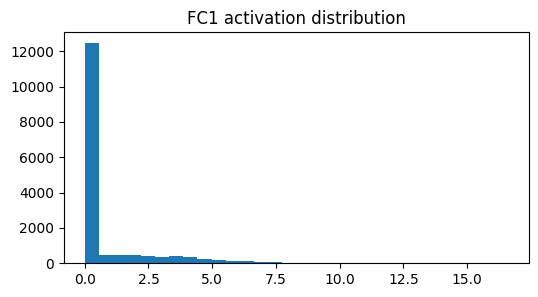

In [48]:
act = cnn.activations["fc1"].detach().cpu().numpy().flatten()

plt.figure(figsize=(6,3))
plt.hist(act, bins=30)
plt.title("FC1 activation distribution")
plt.show()


In [77]:
nns_name = model_manager.get_available_models()
for nn_name in nns_name:
    nn = model_manager.get_model(nn_name)
    total = accuracy = 0
    time_1 = time.time()
    for x, y in test_loader_mnist:
        for xi, yi in zip(x, y):
            xi_in = xi.view(1, -1).float()
            _, pred, _ = model_manager.predict(nn, xi_in)
            accuracy += int(pred == yi)
            total += 1
        break
    print(nn_name, total, accuracy, time.time() - time_1, (time.time()-time_1) / total)


Perceptron 128 123 0.014019489288330078 0.00010952726006507874
MLP 128 128 0.04807710647583008 0.0003756023943424225
CNN 128 127 0.11960840225219727 0.0009344406425952911


In [ ]:
nns_name = model_manager.get_available_models()
for nn_name in nns_name:
    nn = model_manager.get_model(nn_name)
    total = accuracy = 0
    time_1 = time.time()
    for x, y in test_loader_mnist:
        preds = torch.argmax(nn(x), dim=1)
        accuracy += (preds == y).sum().item()
        total += y.size(0)
    print(nn_name, total, accuracy, time.time() - time_1, (time.time()-time_1) / total)

In [1]:
n_classes = 10

nns_name = model_manager.get_available_models()

for nn_name in nns_name:
    nn = model_manager.get_model(nn_name)
    
    total = 0
    correct = 0
    conf_mat = torch.zeros(n_classes, n_classes, dtype=torch.int32)

    time_1 = time.time()
    
    for x, y in test_loader_mnist:
        for xi, yi in zip(x, y):
            xi_in = xi.view(1, -1).float()
            probs_dict, pred, _ = model_manager.predict(nn, xi_in)
            
            correct += int(pred == yi)
            total += 1

            conf_mat[yi, pred] += 1

    print(f"=== {nn_name} ===")
    print(f"Total: {total}")
    print(f"Accuracy: {correct / total:.4f}")
    print("Confusion Matrix:")
    print(conf_mat)
    print(f"Time: {time.time() - time_1:.2f} sec")


NameError: name 'model_manager' is not defined

In [10]:
n_classes = 10

nns_name = model_manager.get_available_models()

for nn_name in nns_name:
    nn = model_manager.get_model(nn_name)
    
    total = 0
    correct = 0
    conf_mat = torch.zeros(n_classes, n_classes, dtype=torch.int32)

    time_1 = time.time()
    
    for x, y in test_loader_mnist:
        x = x.float()
        with torch.no_grad():
            outputs = nn(x)
            preds = torch.argmax(outputs, dim=1)

            correct += (preds == y).sum().item()
            total += y.size(0)

            for t, p in zip(y, preds):
                conf_mat[t, p] += 1

    print(f"=== {nn_name} ===")
    print(f"Total: {total}")
    print(f"Accuracy: {correct / total:.4f}")
    print("Confusion Matrix:")
    print(conf_mat)
    print(f"Time: {time.time() - time_1:.2f} sec")


=== Perceptron ===
Total: 10000
Accuracy: 0.9232
Confusion Matrix:
tensor([[ 959,    0,    1,    1,    0,    5,    8,    4,    2,    0],
        [   0, 1111,    3,    2,    1,    2,    4,    2,   10,    0],
        [   8,   11,  914,   19,   11,    3,   13,   11,   39,    3],
        [   3,    0,   18,  920,    0,   27,    2,   11,   21,    8],
        [   1,    1,    2,    1,  922,    0,   14,    2,    9,   30],
        [   8,    2,    3,   30,   10,  773,   18,    7,   33,    8],
        [   9,    3,    5,    1,    8,   12,  917,    2,    1,    0],
        [   1,    5,   22,    8,    5,    0,    0,  953,    2,   32],
        [   7,    7,    7,   25,    9,   27,   11,   15,  857,    9],
        [  11,    7,    1,   12,   33,    8,    0,   25,    6,  906]],
       dtype=torch.int32)
Time: 1.14 sec
=== MLP ===
Total: 10000
Accuracy: 0.9762
Confusion Matrix:
tensor([[ 964,    0,    2,    2,    0,    4,    3,    1,    4,    0],
        [   0, 1127,    1,    2,    0,    1,    1,    0,    3